# Simulate & Extract a Composite Object

This notebook demonstrates how to extract a composite object using the ```fluxcube``` functionality.  The ```fluxcube``` functionality really expects an extended source, therefore the simulations from previous notebooks are not sufficient.  Therefore we will also create a simple composite source, and much of the operations may appear familiar at this point.

***As a word of caution.***  This work is on the cutting edge of ```pyLINEAR```, and the place were I am actively developing.  Therefore, I expect a number of aspects may change.

## Notebook History:

1. started by Russell Ryan Aug 3, 2020
2. latest version by Russell Ryan Aug 11, 2020

In [1]:
import pylinear
import numpy as np
from astropy.io import fits
from astropy.modeling import models
from astropy import wcs
from skimage.morphology import label
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import glob
import shutil
import os

info> Loading source catalog
info> Loading an observational catalog
debug> implement source filtering
info> Loading sources from CLASSIC segmentation map
info> Loading broadband photometry
info> Loaded 227 sources
info> Loading grism collection
info> Loading simulated grism images
info> Loaded 24 images
debug> Figure out if remake works right
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debu

In [2]:
pixfile = 'pix_comp.fits'     # segmap with each pixel different ID (for simulation)
segfile = 'seg_comp.fits'     # segmap with a constant ID (for extraction)
imgfile = 'img_comp.fits'
obslst  = 'obs_comp.lst'
wcslst  = 'wcs_comp.lst'
fltlst  = 'flt_comp.lst'
pdtpath = 'tables_comp'
beam    = '+1'
sedlst  = 'sed_comp.lst'
seddir  = 'seds_comp'
root    = 'single_comp'
logdamp = -4.0 #[-5,-1,0.1]
method  = 'single' #'grid'
cubeid  = 1                   # indicates which SEGID should be treated as a composite
size    = (1000,1000)
crval   = (53.0,-27.0)
pixscl  = 0.060
maglim  = 99.0                # flux limit should be very high (allow individual pix)

### Step 1. Make Simulated Data

This will go much faster now that we've seen how to make direct images.  I won't break it down like before to just streamline the process.  The primary goals will be:

1. Create an extended source direct image and segementation map;
2. Add a ring of emission-line flux in the source; and
3. Create a spectrum for each pixel in this segmentation map and store in a temporary directory.

But given the way ```pyLINEAR``` works, in particular the simulation parts, we will create *two* segmentation maps: one for the whole source (for the extraction phase) and one where each pixel is a unique ID (for the simulation phase).

In [30]:
# step 1.  Making direct images

# create the coordinates
x,y = np.meshgrid(np.arange(size[0]), np.arange(size[1]))

# properties of the galaxy
prop = {'amplitude': 1., 'r_eff': 10.,'n': 1.,'x_0':size[1]/2.,
        'y_0': size[0]/2.,'ellip': 0.5,'theta': 35.}


# create the galaxy continuum
func = models.Sersic2D(**prop)
cont = func(x,y)


# create a ring of emission line

# first, rotate the coordinate system
cs,sn = np.cos(prop['theta']*np.pi/180.), np.sin(prop['theta']*np.pi/180.)
xr =  (x-prop['x_0'])*cs + (y-prop['y_0'])*sn
yr = -(x-prop['x_0'])*sn + (y-prop['y_0'])*cs

# next, create a radial fnction 
rad = np.sqrt((xr*(1-prop['ellip']))**2 + yr**2)
r,s = 5.,1.                                   # radius,width of the ring
z = (rad-r)/s                                 # create a temporary variable at 5 pix away
ring = 10.*np.exp(-0.5*z*z)/(2*np.pi*s*s)     # the ring of emission line

# finally, make the composite direct image
img = cont + ring

# create a segmentation map for the extraction
seg = label(rad < 6)
gy,gx = np.where(seg == 1)     # get the pixels in the segmap

# create a pixelized segmentation map for the simulation
pix = np.zeros_like(seg)


# now make unique spectrum for each pixel in the extended source

lamb = np.arange(7400,12601,1)    # dummy wavelength array
l0 = 9000.                        # center the line at 9000 A
sig = 25.                         # width of emm line

# create the emmission line spectrum
z=(l0-lamb)/sig
emm = np.exp(-0.5*z*z)


# check that the seddir exists, make it if not.
if not os.path.isdir(seddir):
    os.mkdir(seddir)
    
# process each pixel
with open(sedlst,'w') as sedfile:
    for j,(yy,xx) in enumerate(zip(gy,gx)):
        # create a segid:
        segid = j+1       # cant start at 0, that's the sky!
        
        thisfile = os.path.join(seddir,'{}.sed'.format(segid))

        # update the SEDFILE
        print('{} {}'.format(segid,thisfile),file=sedfile)
        
        
        # create this spectrum. 
        flam = ring[yy,xx]*emm + cont[yy,xx]
                
        # output this spectrum
        with open(thisfile,'w') as fp:
            for l,f in zip(lamb,flam):
                print('{} {}'.format(l,f),file=fp)
        
        # update the pixelized segmentation map
        pix[yy,xx] = segid

        
# make a WCS 
w=wcs.WCS(naxis=2)
w.wcs.crpix=[size[0]/2,size[1]/2]
w.wcs.crval=crval
w.wcs.ctype=['RA---TAN','DEC--TAN']
w.wcs.cd=[[-pixscl/3600.,0],[0,pixscl/3600]]
hdr=w.to_header()
       
        
# write out the imaging products
fits.writeto(segfile,seg,header=hdr,overwrite=True)
fits.writeto(imgfile,img,header=hdr,overwrite=True)
fits.writeto(pixfile,pix,header=hdr,overwrite=True)

# ok, maybe pause here and look at the files seg_comp.fits, pix_comp.fits, 
# and img_comp.fits to see that they make sense.  Also, check out the seds_comp 
# directory, and see how those files fit with respect to the pix_comp.fits file.

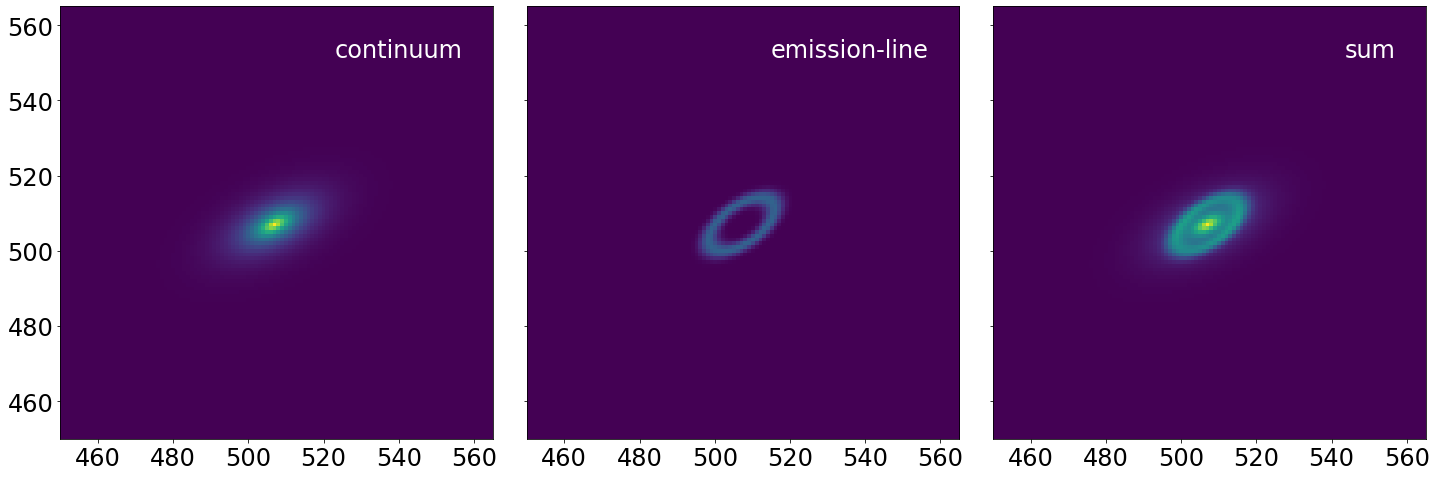

In [41]:
# Step 1b (optional).  Let's just look at the data we created

vmin,vmax=0.,5    # display ranges

# let's look at the spatial components
fig,(left,middle,right)=plt.subplots(1,3,sharex=True,sharey=True,figsize=(20,20))
left.imshow(cont,origin='lower',vmin=vmin,vmax=vmax)
left.text(0.93,0.87,'continuum',transform=left.transAxes,color='white',
         verticalalignment='bottom',horizontalalignment='right',fontsize=24)
left.tick_params(axis='both', which='major', labelsize=24)


middle.imshow(ring,origin='lower',vmin=vmin,vmax=vmax)
middle.text(0.93,0.87,'emission-line',transform=middle.transAxes,color='white',
         verticalalignment='bottom',horizontalalignment='right',fontsize=24)
middle.tick_params(axis='both', which='major', labelsize=24)


right.imshow(img,origin='lower',vmin=vmin,vmax=vmax)
right.text(0.93,0.87,'sum',transform=right.transAxes,color='white',
             verticalalignment='bottom',horizontalalignment='right',fontsize=24)
right.tick_params(axis='both', which='major', labelsize=24)


# zoom-in on the object
left.set_xlim(450,565)
left.set_ylim(450,565)

# reduce the space
fig.tight_layout()

# Step 2. Simulate Grism Images

Hopefully the process of simulating grism images with ```pyLINEAR``` is familiar, so we will step through this very quickly.  The difference now is that we will use the ```pix_comp.fits``` file to simulate, as that breaks down each constituent pixel in the segmentation map with a unique ID and hence spectrum.

In [4]:
# step 2. Simulating Grism Images 

# make a wcs list.  We will have many unknowns, so we need many observations: consider
# 3 dithers per orient and 8 orients
ndither = 3
orients = np.arange(0,360,45)
ind = 1           # a counter
with open(wcslst,'w') as fp:
    print('# TELESCOPE = HST',file=fp)
    print('# INSTRUMENT = WFC3',file=fp)
    print('# DETECTOR = IR',file=fp)
    print('# BLOCKING = ',file=fp)
    for orient in orients:
        for i in range(ndither):
            delta = float(i)/1000.
            ra,dec = 53.+delta,-27.+delta
            print('comp{} {} {}  {}  G102'.format(ind,ra,dec,orient),file=fp)
            ind += 1    # increment our counter

            
# make an obslst file
with open(obslst,'w') as fp:
    print('{} hst_wfc3_f105w'.format(imgfile),file=fp)
            
            
# load the sources
sources=pylinear.source.SourceCollection(pixfile,obslst,detindex=0,maglim=maglim)

# load the grism images
grisms=pylinear.grism.GrismCollection(wcslst,observed=False)
    
# make the PDTs
tabulate=pylinear.modules.Tabulate('pdt',path=pdtpath,ncpu=0)
pdtnames=tabulate.run(grisms,sources,beam)
    
# run the simulation
simulate=pylinear.modules.Simulate(sedlst,path=pdtpath,ncpu=0,gzip=False)
filenames=simulate.run(grisms,sources,beam)

   227: 100%|██████████| 227/227 [00:01<00:00, 117.19it/s]


### Step 3.  Add Photometric noise.

This part is exactly the same as the previous notebook, except before we used ```file``` as the basename for our files, and here we're using ```comp```.  This keeps our files clear in the workspace.

In [5]:
# step 3. Add Noise.  Use similar code to before.
sig = 0.001     # small sigma, for same reason as before

# while doing this, let's make the FLT lst as well to save time
with open(fltlst,'w') as fp:
    for oldf in glob.glob('comp*flt.fits'):
        # let's save the file in case we want to compare
        savefile = oldf+'_saved'
        shutil.copyfile(oldf,savefile)

        # update the FLT lst
        print(oldf,file=fp)               # this will be the noised images
        
        
        # open the fits file
        with fits.open(oldf) as hdul:
            sci = hdul[('SCI',1)].data    # the science image
            size = sci.shape              # dimensionality of the image
        
            # update the science extension with random noise
            hdul[('SCI',1)].data = sci + np.random.normal(loc=0.,scale=sig,size=size)
        
            # update the uncertainty extension with the sigma
            hdul[('ERR',1)].data = np.full_like(sci,sig)
        
            # now write to a new file name
            hdul.writeto(oldf,overwrite=True)

### Step 4. Extraction

This is where things deviate most for ```pyLINEAR```, and they are:
1.  one must specify when loading the sources the unique source that is a composite.  At present, ```pyLINEAR``` only permits a single composite source.  This is something I'd like to address in the future, but the catch is to balance knowns and unknowns.  
2.  we now use the ```extract2d``` method.  This will change the output products; there will still be a ```_lcv.pdf```, but now will include an ```_x2d.fits```.  The ```extract2d``` method does not allow for grouping; this is just something that has not been implemented yet.

***Caution!!!*** This will be very slow!


In [6]:
# step 4. Extract.  Follow the same steps as before.

# load the sources.  NOTE! Here we want to use the fluxcube set up
sources = pylinear.source.SourceCollection(segfile,obslst,detindex=0,cubeid=cubeid,maglim=maglim)

# load the grism images
grisms = pylinear.grism.GrismCollection(fltlst,observed=True)

# make the PDTs
tabulate = pylinear.modules.Tabulate('pdt',path=pdtpath,ncpu=0)   # note the ncpu = 0
tabnames = tabulate.run(grisms,sources,beam)

# Set default extraction ranges
extraction_parameters = grisms.get_default_extraction()
sources.update_extraction_parameters(*extraction_parameters)

# Do the extractions.  NOTE! here we are using the method extract2d!!
pylinear.modules.extract.extract2d(grisms,sources,beam,logdamp,method,root,pdtpath)

Loading ODTs: 100%|██████████| 24/24 [00:24<00:00,  1.01s/it]


### Step 5. Look at results

The ```_x2d.fits``` file is a standard IFU-like file and can be studied with ```ds9```, so open it up and have a looksy.

### Step 6 (optional).  Fit the IFU cube to recover the emission-line signal.

This is not necessary to simulate/extract IFU-like flux cubes, but is interesting to understand the results. 

We put in spectrum that was a Gaussian-emission line whose amplitude varied like a ring and a ```f_lamb = const``` spectrum, where the const scaled like an exponetial disk.  Therefore, let's fit this spectrum to each pixel in the cube and recover the emission-line ring.

In [7]:
def gauss(x,a,mu,sig,cont):       # a function to fit the constant+Gaussian
    z=(x-mu)/sig
    return cont + a * np.exp(-0.5*z*z)

# open the result
with fits.open('{}_x2d.fits'.format(root)) as hdul:
    cube = hdul[1].data
    head = hdul[1].header
    
    # get dimensionalities
    nwave,ny,nx = cube.shape
    
    # create the wavelength grid from the inputs
    w0 = head['CRVAL3']
    dw = head['CD3_3']
    wave = np.arange(w0,w0+dw*nwave,dw)

    # create output images
    cont = np.zeros((ny,nx))      # the measured continuum
    emm = np.zeros_like(cont)     # the measured emmission line-flux
    
    
    # process each pixel
    for y in range(ny):
        for x in range(nx):
            flam = cube[:,y,x]    # the pyLINEAR-measured spectrum
            
            # pyLINEAR sets unmeasured spaxels to nan, so we need to patch
            # those up to fit.  There are probably better ways to do this
            g = np.where(np.isnan(flam))
            flam[g]= 0.
            
            # fit the model spectrum
            p0=[max(flam),9000.,25.,min(flam)]   # initial guess
            popt,pcov = curve_fit(gauss,wave,flam,p0=p0)
            
            # subtract off the continuum
            cube[:,y,x]-=popt[3]

            # save the continuum
            cont[y,x]=popt[3]
            
            # save the emission line flux.  Recall that the model is unnormalized
            emm[y,x]=popt[0]*np.sqrt(2*np.pi)*popt[2]
            
    # write the results out
    fits.writeto('{}_contsub.fits'.format(root),cube,header=head,overwrite=True)
    fits.writeto('{}_cont.fits'.format(root),cont,header=head,overwrite=True)
    fits.writeto('{}_emm.fits'.format(root),emm,header=head,overwrite=True)
    
    
# this outputs 3 fits files:
# contsub.fits = the IFU-flux cube with the continuum subtracted off
#    cont.fits = the continuum flux level as a 2d image
#     emm.fits = the integrated line flux as a 2d image

/Users/rryan/miniconda3/envs/astroconda37/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


### Step 7 (optional). Inspect Results

The main output of ```pyLINEAR``` will be the ```_x2d.fits``` file, which is written using the ESA-standard for IFU data and can be visualized in ```ds9```.  Let's inspect both this file, and the three files we made from the previous cell.  Therefore we will be looking at these four files:

1. ```x2d.fits```: the raw output from ```pylinear```
2. ```contsub.fits```: the continuum subtracted ```x2d.fits``` 
3. ```cont.fits```: the continuum measured from ```x2d.fits``` 
4. ```emm.fits```: the wavelength-integrated emission line map.

The first two items on our list are three-dimensional and stored as multi-extension fits (MEF) files, while the last two are just two-dimesional.  Let's start with the MEF files:

``` ds9 single_comp_x2d.fits single_comp_contsub.fits &```

You will get a cube pop-up window that controls the wavelength slice that is visualized.  However, as you change the wavelength slice, ```ds9``` will change the brightness ranges and will give you a false sense of understanding.  Therefore, I recommend manually setting the scale ranges by hand before playing with the wavelength slicer.  Use the pulldown menu: ```Scale > Scale Parameters ... ``` which will show a pixel histogram.  Let's use the values ```-0.01``` and ```0.01```, and lock the displays with the pulldown command: ```Frame > Lock >``` and click the ```Scale``` and ```Colorbar```. But also lock the slicer: ```Frame > Lock > Slice > Image``` so that both windows display the same wavelength.  As you can see, the left panel shows a bright bulge and at 9000 A you can see the emission-line ring light up.  However, if you look at the right panel, you see the bulge is completely gone as we have subtracted the continuum light that is associated with the bulge.

Now look at the last 2 files:

```ds9 single_comp_cont.fits single_comp_emm.fits &```

Similarly force the ```Scale > Scale Parameters``` and lock those frames ``` Frame > Lock >``` as before.  These are just 2d images, but you can see the contributions from the continuum model (a constant in flam) and the emission-line (Gaussian in wavelength).

There are other visualizations one can do, but this should get you started.  But a more realistic test would use galaxy SEDs for the continuum.

## Command-Line Interface Usage:

The extraction of the 2d spectra for the composite object can be streamlined with the command:

```
prompt> pylinear --fluxcube --segfile seg_comp.fits --obslst obs_comp.lst --imglst flt_comp.lst --path tables_comp --sedlst sed_comp.lst --beams +1 --method single --logdamp -4.0 --cubeid 1
```

Many of these settings are probably clear at this point, but the first flag ```--fluxcube``` tells ```pylinear``` to do the 2d-fluxcube extraction (and can be shortened with ```-f```).